In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from datetime import timedelta, date, datetime
from sqlalchemy.types import NVARCHAR, DATE, FLOAT, VARCHAR, DATETIME
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_roc_curve,\
    plot_confusion_matrix, recall_score, precision_score, accuracy_score

from helpers import *

data_dir = "../data"

sns.set_style('whitegrid')



## Feature extraction

In [ ]:
from sqlalchemy import create_engine

import pandas as pd
import config
from sql_queries import *

engine = create_engine(
    f"mysql+pymysql://{config.sql_credentials['user']}:{config.sql_credentials['password']}@{config.sql_credentials['host']}:{config.sql_credentials['port']}/{config.sql_credentials['db']}",
    pool_pre_ping=True)

conn = engine.connect()
#
# print(datetime.now())
# login_data = pd.read_sql(login_query, conn)
# print(datetime.now())
# dist_data = pd.read_sql(dist_query, conn)
# print(datetime.now())
# prefs_data = pd.read_sql(prefs_query, conn)
# print(datetime.now())
# training_data = pd.read_sql(training_query, conn)
# print(datetime.now())
# worked_data = pd.read_sql(worked_query, conn)
# print(datetime.now())
#
# login_data.to_csv('../data/login_data.csv', index = False)
# dist_data.to_csv('../data/dist_data.csv', index = False)
# worked_data.to_csv('../data/worked_data.csv', index = False)
# prefs_data.to_csv('../data/prefs_data_v2.csv', index = False)
# training_data.to_csv('../data/training_data_v2.csv', index = False)


prefs_data = pd.read_sql(prefs_query, conn)
prefs_data.to_csv('../data/prefs_data_v2.csv', index = False)

## Feature engineering

In [ ]:
login_data = pd.read_csv('../data/login_data.csv')
dist_data = pd.read_csv('../data/dist_data.csv')
worked_data = pd.read_csv('../data/worked_data.csv')
prefs_data = pd.read_csv('../data/prefs_data_v2.csv')
training_data = pd.read_csv('../data/training_data_v2.csv')


In [ ]:
print(training_data.shape)
all_data = training_data.merge(login_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(prefs_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(dist_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(worked_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)

all_data.drop_duplicates(subset=['placement_ad_id','carer_id','sent_at'], inplace = True)
print(all_data.shape)

In [ ]:
all_data.columns

In [ ]:
all_data.carer_age.isna().sum()

In [ ]:
all_data['carer_applied_in_8hrs'].value_counts()

In [ ]:
target = 'carer_applied_in_8hrs'

X1 = all_data.loc[all_data['carer_applied_in_8hrs']==1]
X0 = all_data.loc[all_data['carer_applied_in_8hrs']==0].sample(frac=0.01, random_state=1992)

df = pd.concat([X1,X0], axis = 0)
df

In [ ]:
pd.get_dummies(df['sms_type'],drop_first=True)
df.columns

## Feature selection

In [ ]:
predictors = ['lead_time', 'min_provider_rate',
       'ongoing', 'min_provider_rate', 'one_off_payments_total',
       'licence_needed', 'car_needed', 'moving_handling', 'dementia',
       'mental_health_issues', 'hoist', 'parkinsons', 'stroke', 'alzheimers',
       'stoma', 'diabetes', 'peg', 'has_wifi', 'smoking', 'has_pets',
       'has_two_crs']
X_train, X_eval, y_train, y_eval = split_train_test(df,predictors,target, test_size=0.15)

In [ ]:
model = LogisticRegression()


In [ ]:
n_features =8
X = X_train
y = np.ravel(y_train)

recall_scorer = make_scorer(recall_score, greater_is_better=True)
results = select_features(model, n_features, y, X,scoring=recall_scorer)

In [ ]:
f_predictors = list(set(sum(list(results.loc[results.cv_score == results.cv_score.max()]['features']), [])))

In [ ]:
heat_list = f_predictors + [target]

fig, ax = plt.subplots(1, 2, figsize=(25, 8))

sns.lineplot(x=range(1, n_features), y=results['cv_score'], ax = ax[0], linewidth = 3)
sns.heatmap(training_data[heat_list].corr(), cmap='Blues', annot=True, ax = ax[1])

## Model performance

### Baseline

In [ ]:
model.fit(X_train[f_predictors], y)

In [ ]:
preds = model.predict(X_eval[f_predictors])
print(f'Precision is {precision_score(y_eval,preds)}, recall is {recall_score(y_eval,preds)}, accuracy is {accuracy_score(y_eval,preds)}')

On a balanced sample (around 50% each applied/not applied), the model does a fair job at classifying positive examples
correctly, showing an accuracy of 58.4% together with a recall score of 61.2% on the evaluation set (not used for FS)

In [ ]:
plot_confusion_matrix(model,X_eval[f_predictors],y_eval)

Feature predictive importance is line with expectations,bonuses possibly reflecting location

In [ ]:
plot_shap_metrics(model,df,predictors,target)

### Including soft preferences





In [ ]:
<<<<<<< REMOTE CELL DELETED >>>>>>>
import pandas as pd
import numpy as np
import seaborn as sns
import os
from datetime import timedelta, date, datetime
from sqlalchemy import create_engine
from sqlalchemy.types import NVARCHAR, DATE, FLOAT, VARCHAR, DATETIME
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_roc_curve,\
    plot_confusion_matrix, recall_score, precision_score, accuracy_score


import config
from sql_queries import *
from helpers import *

data_dir = "data"

engine = create_engine(
    f"mysql+pymysql://{config.sql_credentials['user']}:{config.sql_credentials['password']}@{config.sql_credentials['host']}:{config.sql_credentials['port']}/{config.sql_credentials['db']}",
    pool_pre_ping=True)

conn = engine.connect()

sns.set_style('whitegrid')


In [44]:
# print(datetime.now())
# login_data = pd.read_sql(login_query, conn)
# print(datetime.now())
# dist_data = pd.read_sql(dist_query, conn)
# print(datetime.now())
# prefs_data = pd.read_sql(prefs_query, conn)
# print(datetime.now())
# training_data = pd.read_sql(training_query, conn)
# print(datetime.now())
# worked_data = pd.read_sql(worked_query, conn)
# print(datetime.now())

login_data = pd.read_csv('../data/login_data.csv')
dist_data = pd.read_csv('../data/dist_data.csv')
worked_data = pd.read_csv('../data/worked_data.csv')
prefs_data = pd.read_csv('../data/prefs_data_v2.csv')
training_data = pd.read_csv('../data/training_data_v2.csv')



In [58]:
print(training_data.shape)
all_data = training_data.merge(login_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(prefs_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(dist_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(worked_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)

all_data.drop_duplicates(subset=['placement_ad_id','carer_id','sent_at'], inplace = True)
print(all_data.shape)

(1963934, 36)
(1965009, 40)
(1965009, 53)
(1965009, 54)
(1965009, 58)
(1963934, 58)


In [47]:
all_data.columns

Index(['Unnamed: 0', 'placement_ad_id', 'match_request_id_x', 'carer_id',
       'sent_at', 'updated_at', 'sms_type', 'carer_applied_in_8hrs_x',
       'lead_time', 'ongoing', 'min_provider_rate', 'one_off_payments_total',
       'licence_needed', 'car_needed', 'moving_handling', 'dementia',
       'mental_health_issues', 'hoist', 'parkinsons', 'stroke', 'alzheimers',
       'stoma', 'diabetes', 'peg', 'has_wifi', 'smoking', 'has_pets',
       'has_two_crs', 'max_cr_age', 'recipient_1_male',
       'ethnicities_at_risk_WHITE_ALL', 'ethnicities_at_risk_MIXED_ALL',
       'ethnicities_at_risk_BLACK_ALL', 'ethnicities_at_risk_ASIAN_ALL',
       'ethnicities_at_risk_ARAB_ALL', 'latitude', 'longitude',
       'match_request_id_y', 'timestamp', 'carer_logged_in_7_days',
       'carer_applied_in_8hrs_y', 'carer_logged_in_7_days_n', 'set_at',
       'ethnicityExclusion_ARAB_ALL', 'ethnicityExclusion_ASIAN_ALL',
       'ethnicityExclusion_BLACK_ALL', 'ethnicityExclusion_MIXED_ALL',
       'ethn

In [51]:
all_data['carer_applied_in_8hrs'].value_counts()

0    1946862
1      17072
Name: carer_applied_in_8hrs, dtype: int64

In [59]:
target = 'carer_applied_in_8hrs'

X1 = all_data.loc[all_data['carer_applied_in_8hrs']==1]
X0 = all_data.loc[all_data['carer_applied_in_8hrs']==0].sample(frac=0.01)

df = pd.concat([X1,X0], axis = 0)
df

,placement_ad_id,match_request_id_x,carer_id,sent_at,updated_at,sms_type,carer_applied_in_8hrs,lead_time,ongoing,min_provider_rate,...,maxDistance_100,maxDistance_400,petsExclusion_CATS,petsExclusion_DOGS,recipientNumberExclusion_2CRs,distance_km,match_request_id,start_date_time,carer_worked_in_7_days,carer_worked_in_30_days
17,plad_pl_s062kkx0J0QL_j4cB-d1dabaa0-acbb-4dc1-9...,pl_s062kkx0J0QL_j4cB-d1dabaa0-acbb-4dc1-9754-c...,p100093502,2021-08-17 11:29:26,2021-08-17 11:28:26,initialPromotionSent,1,34,1,700.0,...,0.0,0.0,0.0,0.0,0.0,64.0,pl_s062kkx0J0QL_j4cB-d1dabaa0-acbb-4dc1-9754-c...,2021-08-15 00:00:00,1.0,1.0
25,plad_pl_s01HFZJkHmIL_4BaD-19e7269b-1f1e-4281-a...,pl_s01HFZJkHmIL_4BaD-19e7269b-1f1e-4281-a4c1-2...,p100139148,2019-12-30 11:44:46,2019-12-30 11:36:45,initialPromotionSent,1,7,0,550.0,...,0.0,0.0,0.0,0.0,0.0,346.0,pl_s01HFZJkHmIL_4BaD-19e7269b-1f1e-4281-a4c1-2...,2019-12-30 00:00:00,1.0,1.0
73,plad_pl_s0SmL39RWSVK_buQY-7a0c3a05-036b-453c-8...,pl_s0SmL39RWSVK_buQY-7a0c3a05-036b-453c-8ed6-8...,p100139148,2020-02-07 16:44:36,2020-02-07 16:36:02,initialPromotionSent,1,4,1,550.0,...,0.0,0.0,0.0,0.0,0.0,8.0,pl_s0SmL39RWSVK_buQY-7a0c3a05-036b-453c-8ed6-8...,2020-01-12 00:00:00,0.0,1.0
134,plad_pl_s0cCuetHrFmd_00QZ-dd9a0882-3ea3-4362-8...,pl_s0cCuetHrFmd_00QZ-dd9a0882-3ea3-4362-8c3c-a...,p100146905,2021-07-02 16:17:30,2021-07-02 16:08:38,initialPromotionSent,1,5,0,600.0,...,1.0,0.0,0.0,0.0,0.0,417.0,NaN,NaN,NaN,NaN
388,plad_pl_s063CSCZAYUm_4jbo-e89250f1-628c-4d24-a...,pl_s063CSCZAYUm_4jbo-e89250f1-628c-4d24-a59b-a...,p100481747,2020-08-17 11:45:35,2020-08-17 11:28:30,initialPromotionSent,1,7,1,650.0,...,0.0,1.0,0.0,0.0,0.0,421.0,pl_s063CSCZAYUm_4jbo-e89250f1-628c-4d24-a59b-a...,2020-02-20 00:00:00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131170,plad_pl_s09QdFo1CltW_eAaK-3ffc5d20-ce6a-450a-a...,pl_s09QdFo1CltW_eAaK-3ffc5d20-ce6a-450a-a6de-9...,p31255939,2020-07-20 08:29:12,2020-07-20 08:16:49,initialPromotionSent,0,38,0,550.0,...,0.0,0.0,0.0,0.0,0.0,28.0,pl_s09QdFo1CltW_eAaK-3ffc5d20-ce6a-450a-a6de-9...,2018-11-04 00:00:00,0.0,0.0
601313,plad_pl_s077WJUjMkIp_s7w9-5598db67-40bb-4e8b-b...,pl_s077WJUjMkIp_s7w9-5598db67-40bb-4e8b-b449-b...,p200759391,2021-04-01 08:10:17,2021-03-31 19:45:31,urgentMatchSent,0,2,0,560.0,...,0.0,1.0,0.0,0.0,0.0,19.0,pl_s077WJUjMkIp_s7w9-5598db67-40bb-4e8b-b449-b...,2020-07-31 00:00:00,0.0,0.0
674932,plad_pl_s0htWb5YPVxk_jodF-dd134fc0-ae96-4b4c-9...,pl_s0htWb5YPVxk_jodF-dd134fc0-ae96-4b4c-922f-4...,p250890990,2020-09-30 10:11:04,2020-09-30 10:05:57,urgentMatchSent,0,2,0,580.0,...,0.0,0.0,0.0,0.0,0.0,64.0,NaN,NaN,NaN,NaN
439896,plad_pl_s07WwKbw9RUS_yeQE-476a197c-d10f-4e60-b...,pl_s07WwKbw9RUS_yeQE-476a197c-d10f-4e60-b463-3...,p790247,2021-02-01 14:42:16,2021-02-01 14:36:04,slowMatchingSent,0,12,0,560.0,...,0.0,0.0,0.0,0.0,0.0,177.0,pl_s07WwKbw9RUS_yeQE-476a197c-d10f-4e60-b463-3...,2019-05-28 00:00:00,0.0,0.0


In [60]:
df.columns

Index(['placement_ad_id', 'match_request_id_x', 'carer_id', 'sent_at',
       'updated_at', 'sms_type', 'carer_applied_in_8hrs', 'lead_time',
       'ongoing', 'min_provider_rate', 'one_off_payments_total',
       'licence_needed', 'car_needed', 'moving_handling', 'dementia',
       'mental_health_issues', 'hoist', 'parkinsons', 'stroke', 'alzheimers',
       'stoma', 'diabetes', 'peg', 'has_wifi', 'smoking', 'has_pets',
       'has_two_crs', 'max_cr_age', 'recipient_1_male',
       'ethnicities_at_risk_WHITE_ALL', 'ethnicities_at_risk_MIXED_ALL',
       'ethnicities_at_risk_BLACK_ALL', 'ethnicities_at_risk_ASIAN_ALL',
       'ethnicities_at_risk_ARAB_ALL', 'latitude', 'longitude',
       'match_request_id_y', 'timestamp', 'carer_logged_in_7_days',
       'carer_logged_in_7_days_n', 'set_at', 'ethnicityExclusion_ARAB_ALL',
       'ethnicityExclusion_ASIAN_ALL', 'ethnicityExclusion_BLACK_ALL',
       'ethnicityExclusion_MIXED_ALL', 'ethnicityExclusion_WHITE_ALL',
       'genderExclusion

In [85]:
predictors = ['lead_time', 'min_provider_rate',
       'ongoing', 'min_provider_rate', 'one_off_payments_total',
       'licence_needed', 'car_needed', 'moving_handling', 'dementia',
       'mental_health_issues', 'hoist', 'parkinsons', 'stroke', 'alzheimers',
       'stoma', 'diabetes', 'peg', 'has_wifi', 'smoking', 'has_pets',
       'has_two_crs']
X_train, X_eval, y_train, y_eval = split_train_test(df,predictors,target, test_size=0.15)

In [86]:
model = LogisticRegression()


In [87]:
n_features =8
X = X_train
y = np.ravel(y_train)

recall_scorer = make_scorer(recall_score, greater_is_better=True)
results = select_features(model, n_features, y, X,scoring=recall_scorer)

Running for 1 features
Selected features: ['one_off_payments_total']
Fit summary: 0.5613596614794674 (0.5496311200536552 to 0.5776355675311553)
Running for 2 features
Selected features: ['one_off_payments_total', 'mental_health_issues']
Fit summary: 0.6153183613130319 (0.5648395721925134 to 0.6433142472212866)
Running for 3 features
Selected features: ['one_off_payments_total', 'mental_health_issues', 'smoking']
Fit summary: 0.626522563426928 (0.6115371790596865 to 0.6392724823172785)
Running for 4 features
Selected features: ['one_off_payments_total', 'mental_health_issues', 'peg', 'smoking']
Fit summary: 0.6266563214043804 (0.6118706235411804 to 0.6392724823172785)
Running for 5 features
Selected features: ['one_off_payments_total', 'mental_health_issues', 'stoma', 'peg', 'smoking']
Fit summary: 0.6253436063533812 (0.6082027342447482 to 0.6383689839572193)
Running for 6 features
Selected features: ['one_off_payments_total', 'dementia', 'mental_health_issues', 'stoma', 'peg', 'smoking

/Users/bonaventurapacileo/Documents/mo/carer_targeting/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bonaventurapacileo/Documents/mo/carer_targeting/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

Selected features: ['one_off_payments_total', 'car_needed', 'dementia', 'mental_health_issues', 'stoma', 'peg', 'smoking']
Fit summary: 0.611402977864552 (0.5865191146881288 to 0.6311889525092623)


In [88]:
f_predictors = list(set(sum(list(results.loc[results.cv_score == results.cv_score.max()]['features']), [])))

<AxesSubplot:>

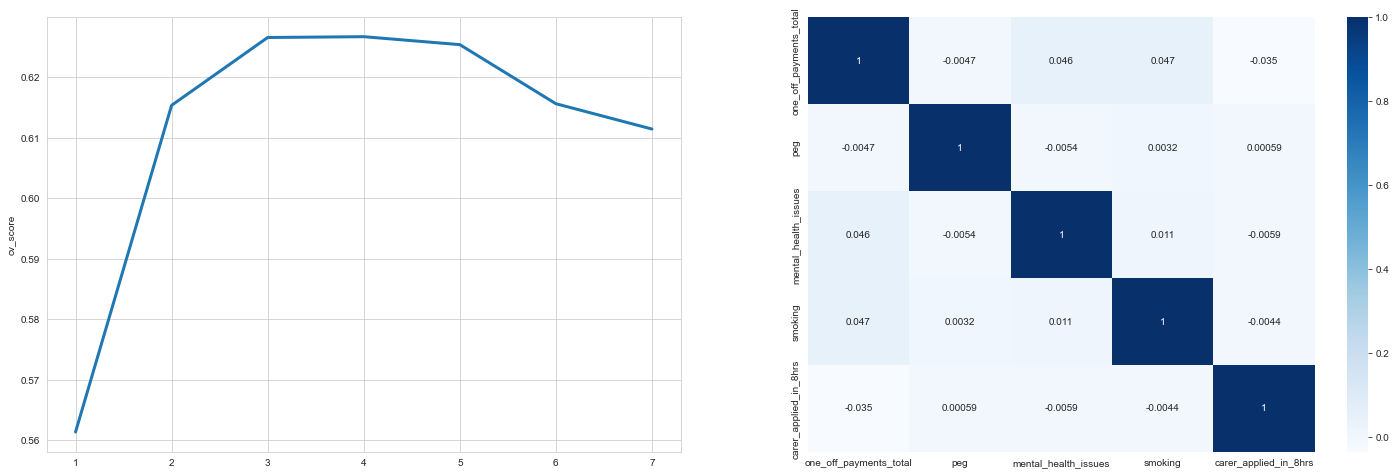

In [89]:
heat_list = f_predictors + [target]

fig, ax = plt.subplots(1, 2, figsize=(25, 8))

sns.lineplot(x=range(1, n_features), y=results['cv_score'], ax = ax[0], linewidth = 3)
sns.heatmap(training_data[heat_list].corr(), cmap='Blues', annot=True, ax = ax[1])

In [90]:
model.fit(X_train[f_predictors], y)


LogisticRegression()

In [91]:
preds = model.predict(X_eval[f_predictors])
print(f'Precision is {precision_score(y_eval,preds)}, recall is {recall_score(y_eval,preds)}, accuracy is {accuracy_score(y_eval,preds)}')

Precision is 0.5572493224932249, recall is 0.6186536291839038, accuracy is 0.5839756228714823


On a balanced sample (around 50% each applied/not applied), the model does a fair job at classifying positive examples
correctly, showing an accuracy of 58.4% together with a recall score of 61.2% on the evaluation set (not used for FS)

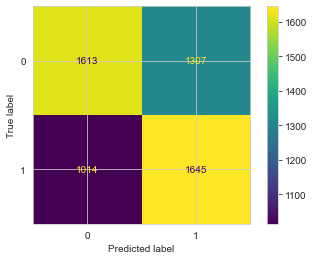

In [92]:
plot_confusion_matrix(model,X_eval[f_predictors],y_eval)

Feature predictive importance is line with expectations,bonuses possibly reflecting location



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

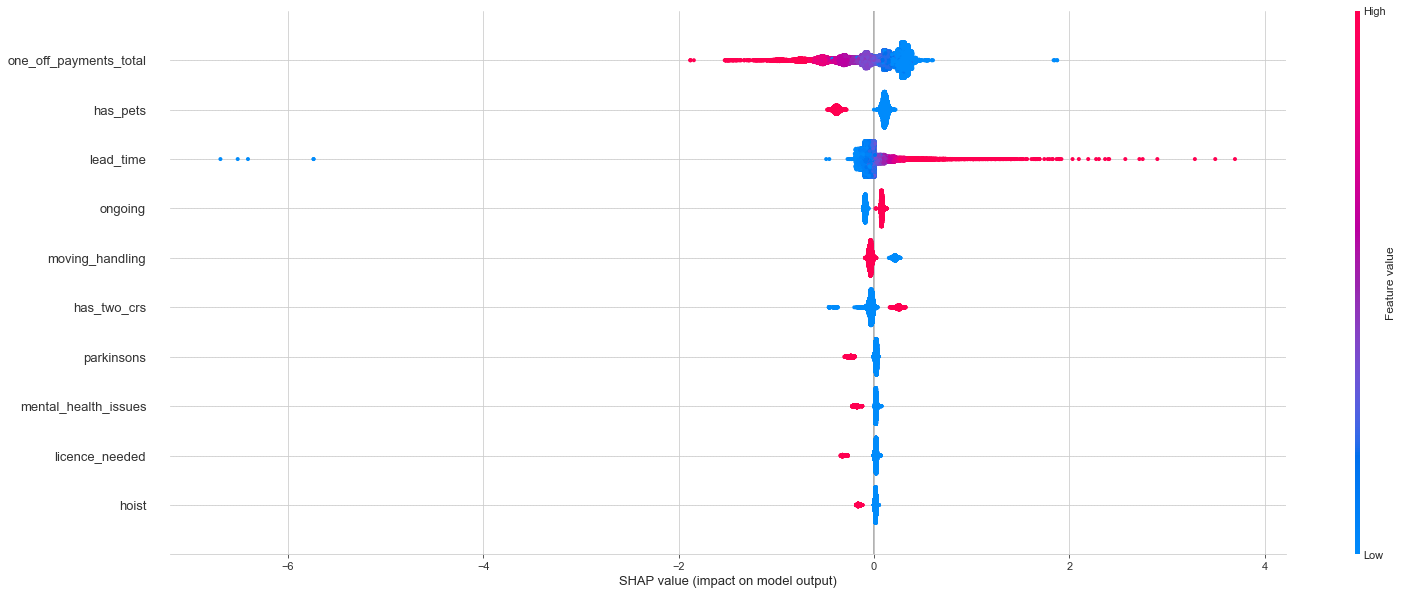

In [93]:
plot_shap_metrics(model,df,predictors,target)

In [6]:

data = pd.read_csv('/Users/bonaventurapacileo/Downloads/bonni_q2.sql.csv')

In [7]:
data

,carer_id,placement_ad_id,sent_at,set_at,ethnicityExclusion_ARAB_ALL,ethnicityExclusion_ASIAN_ALL,ethnicityExclusion_BLACK_ALL,ethnicityExclusion_MIXED_ALL,ethnicityExclusion_WHITE_ALL,genderExclusion_MALE,maxDistance_50,maxDistance_100,maxDistance_400,petsExclusion_CATS,petsExclusion_DOGS,recipientNumberExclusion_2CRs
0,p100032767,plad_pl_s0DyQnvG3lBw_tnCT-b8d6476a-d89e-4952-9...,2020-09-29 14:30:28,2020-09-28 13:37:33,0,0,0,0,0,0,0,0,1,1,1,1
1,p100037528,plad_pl_s03ixZ5n2boc_mNFS-7805b74d-2327-4741-a...,2020-08-20 10:59:55,2020-07-30 14:00:08,0,0,0,0,0,0,0,1,0,0,0,0
2,p100037528,plad_pl_s0dDY73S0c5C_jWip-1b430c7e-cc09-49ec-8...,2020-08-04 13:05:12,2020-07-30 14:00:08,0,0,0,0,0,0,0,1,0,0,0,0
3,p100037528,plad_pl_s0HURQfyMqyw_baqe-42e9dcc6-ec29-493e-9...,2020-08-18 15:44:45,2020-07-30 14:00:08,0,0,0,0,0,0,0,1,0,0,0,0
4,p100037528,plad_pl_s0hxSYNLPFdB_CmNi-d0c5f403-ff92-4354-8...,2020-07-02 13:59:48,NaN,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,p166657835,plad_pl_s0rFhu0of78T_PspZ-92126d80-9103-4d3b-b...,2021-07-14 17:17:36,2021-05-22 17:17:09,0,0,0,0,0,0,0,0,1,0,0,0
49996,p166657835,plad_pl_s0rFhu0of78T_YpYr-a5816d16-f9ee-42a2-8...,2021-07-14 17:18:16,2021-05-22 17:17:09,0,0,0,0,0,0,0,0,1,0,0,0
49997,p166657835,plad_pl_s0rLW3uEkLFF_TsUg-2efedb21-e39a-4cf4-a...,2021-08-12 17:00:08,2021-05-22 17:17:09,0,0,0,0,0,0,0,0,1,0,0,0
49998,p166657835,plad_pl_s0sziIrL8Ouw_ltv2-5d3c0ecc-dd5a-4f63-8...,2021-03-25 14:44:44,NaN,0,0,0,0,0,0,0,0,0,0,0,0
